In [1]:
import so_ml_tools as soml

import tensorflow as tf

from keras import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, GlobalAveragePooling2D, Activation
from keras.losses import sparse_categorical_crossentropy

2023-09-11 14:37:25.358175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Milestome Project 1: Food Vision Big

## Check GPU

Google Colab offers free GPU's, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 from within Google Colab, or if we are using our own hardware our GPU needs a score of 7.0+. See https://developer.nvidia.com/cuda-gpus

In [2]:
!nvidia-smi

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Sep 11 14:37:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0  On |                  Off |
|  0%   41C    P8              15W / 450W |    574MiB / 24564MiB |     16%      Default |
|                                       

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview


In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

datasets_list = tfds.list_builders() # Get all available datasets in TFDS
print("food101" in datasets_list) # Is our target dataset in the list of TFDS?

2023-09-11 14:37:26.615083: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


True


In [4]:
# Load in the data (takes 5-6 minues in Google Colab)
(train_data, test_data), ds_info = tfds.load("food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # Data gets returned in tuple format (data, label)
                                             with_info=True)


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or or are they label encoded)
* Do the labels match up with the class names?

In [5]:
# Features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [7]:
# Take one sample of train data
train_one_sample = train_data.take(1) # Samples are in formate (image_tensor, label)

In [8]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info about our training sample
image = None
label = None
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [10]:
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### PLot an image from TensorFlow Datasets

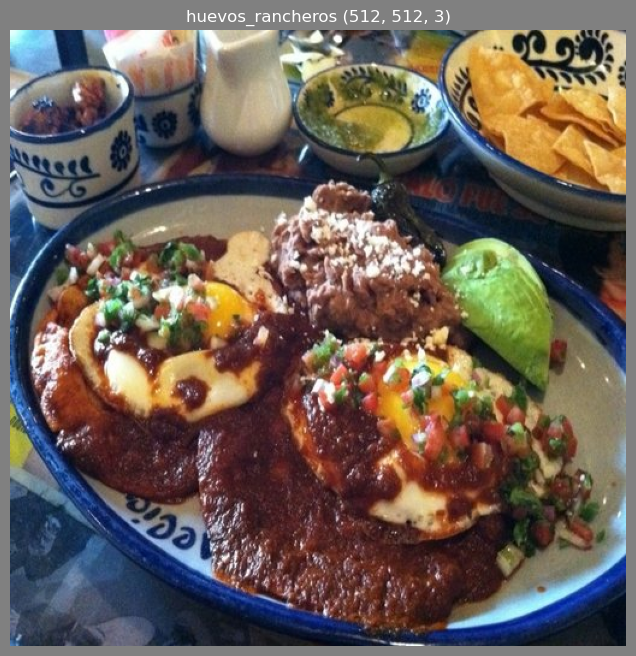

In [11]:
soml.data.image.show_single_image_from_nparray_or_tensor(image=image, title=class_names[label.numpy()])

## Create preprocessing functions for our data

Neural netwroks perform best when data is in a certain way e.g. batched, normalized, etc.

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In 'uint8' datatype.
* Comprised of all different size tensors (different image sizes)
* Not scaled ( the pixel values are between 0 & 255)

What we know models like:
* Data in 'float32' dtype (or for mixed precision 'float16' and 'float32')
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size.
* Scaled (values between 0 & 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling build-in).

This means our function needs to:
1. Reshape our images to all of the the same size
2. Convert the dtype of our image tensors from 'unint8' to 'float32'

In [12]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Coinverts image datatype from 'uint8' -> 'float32' and 
  reshapes image to [img_shape, img_shape, channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # Reshape target image
  # image = image/255. # Scale image values, not required with EfficientNetBX
  return tf.cast(image, tf.float32), label # Return (float32_image, label) tuple

In [13]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing: \n{image[0][:10]}..., \nShape: {image.shape}, Datatype: {image.dtype}")
print(f"Image after preprocessing: \n{preprocessed_img[0][:10]}..., \nShape: {preprocessed_img.shape}, Datatype: {preprocessed_img.dtype}")

Image before preprocessing: 
[[233 253 251]
 [231 253 250]
 [228 254 251]
 [224 255 251]
 [218 255 252]
 [211 255 250]
 [201 255 250]
 [194 255 249]
 [185 255 250]
 [174 253 248]]..., 
Shape: (512, 512, 3), Datatype: <dtype: 'uint8'>
Image after preprocessing: 
[[230.65816  253.64285  251.      ]
 [222.99998  254.97449  252.19388 ]
 [207.06633  255.       250.36734 ]
 [186.92857  254.35715  249.17857 ]
 [168.07652  252.0153   251.7245  ]
 [149.7908   245.03061  250.5051  ]
 [133.61734  233.57143  245.4847  ]
 [127.2704   221.62755  253.4847  ]
 [112.14286  204.14285  243.      ]
 [117.918365 203.0051   248.92857 ]]..., 
Shape: (224, 224, 3), Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly recommend ging through the following guide: http://tensorflow.org/guide/data_performance (Data input pipelines)

In [14]:
# Map preprocessing function to training (and parallizing)
train_data_pre = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch is (load it faster)
train_data_pre = train_data_pre \
  .shuffle(buffer_size=1000) \
  .batch(batch_size=32) \
  .prefetch(buffer_size=tf.data.AUTOTUNE) # Size of buffer can be done on len(train_data) but does require a lot of memory.

# Map preprocessing function to the test data
test_data_pre = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batch_size=32) \
  .prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

"Het, tensorFlow, map this preprocessing function (preprocess_img) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch,"

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TrensorBoard callback to log training results, so we can visualize then later.
* ModelCheckpoint callback to save our models progress after feature extraction

In [16]:
# Create tensorboard callback
tensorboard_callback = soml.tf.fit.callback.tensorboard_callback(
    experiment_name="EfficientV2B0_101_classes_all_data_feature_extract")

# Create ModelCheckpoint callback to save models progress during training
modelcheckpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(
    experiment_name="EfficientV2B0_101_classes_all_data_feature_extract", 
    metric="val_loss", 
    save_weights_only=True, 
    save_best_only=True,
    verbose=0)

Saving TensorBoard log files to: ./logs/EfficientV2B0_101_classes_all_data_feature_extract/20230911-143727


## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [17]:
# Turn on mixed precision training
soml.tf.mixed_precision.set_mixed_precision_policy_for_gpu()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9


In [18]:
!nvidia-smi

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Sep 11 14:37:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0  On |                  Off |
|  0%   42C    P2              37W / 450W |  22680MiB / 24564MiB |      6%      Default |
|                                       

## Build feature extraction model

In [19]:
# Create base model
INPUT_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create functional modal
input_layer = Input(shape=INPUT_SHAPE, name="input_layer")
# x = Rescaling(scale=1/255.)(input_layer)
x = base_model(input_layer, training=False) # Make sure layers which should be in inference mode only stay like that
x = GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
x = Dense(units=len(class_names), activation=None, name="output_dense_layer")(x)
output_layer = Activation(activation='softmax', dtype=tf.float32, name="output_activation_layer")(x)
model = Model(input_layer, output_layer)

model.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(),
              metrics=["accuracy"])

In [20]:
soml.tf.model.layer.list_model(model=model, recursive=False)

row   | name (type)                                        | dtype   | policy        | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)]   
1     | efficientnetv2-b0         (Functional            ) | float32 | mixed_float16 | False     | (None, None, None, 1280)
2     | global_average_pooling_2d (GlobalAveragePooling2D) | float32 | mixed_float16 | True      | (None, 1280)            
3     | output_dense_layer        (Dense                 ) | float32 | mixed_float16 | True      | (None, 101)             
4     | output_activation_layer   (Activation            ) | float32 | float32       | True      | (None, 101)             


Going through the above we can see that the layers efficientnetv2-b0, global_average_pooling_2d and output_dense_layer are storing their values in float32 but compute using mixed_float16.

In [21]:
soml.tf.mixed_precision.get_mixed_precision_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:

1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [22]:
# Fit the feature extraction model

history_101_food_classes_feature_extract = model.fit(train_data_pre,
                    steps_per_epoch=len(train_data_pre),
                    validation_data=test_data_pre,
                    validation_steps=int(0.15 * len(test_data_pre)),
                    epochs=3,
                    callbacks=[tensorboard_callback, modelcheckpoint_callback])

Epoch 1/3
2368/2368 [==============================] - 24s 8ms/step - loss: 1.7483 - accuracy: 0.5768 - val_loss: 1.1535 - val_accuracy: 0.6947
Epoch 2/3
2368/2368 [==============================] - 19s 8ms/step - loss: 1.2138 - accuracy: 0.6863 - val_loss: 1.0540 - val_accuracy: 0.7148
Epoch 3/3
2368/2368 [==============================] - 19s 8ms/step - loss: 1.0649 - accuracy: 0.7219 - val_loss: 1.0031 - val_accuracy: 0.7267


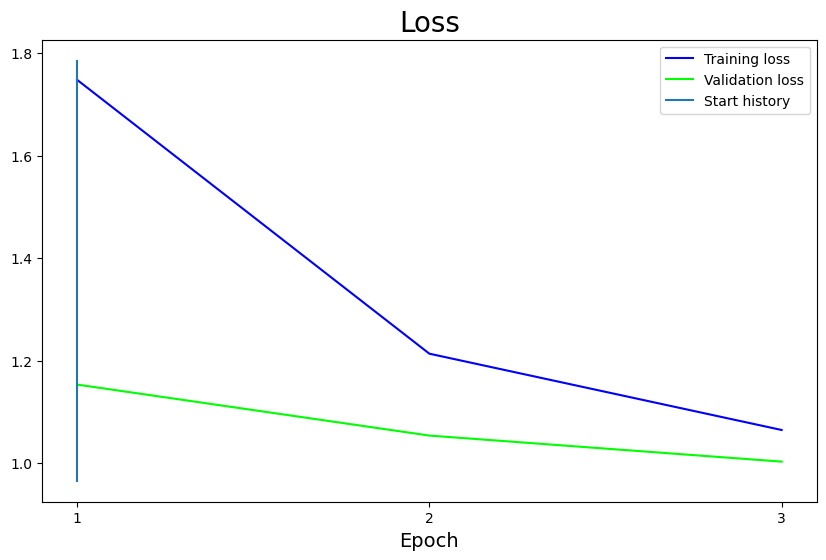

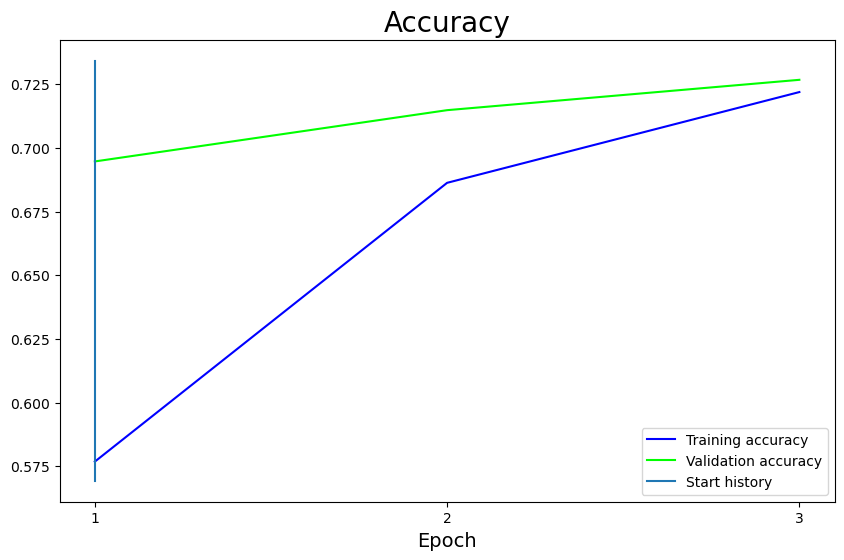

In [23]:
soml.tf.model.plot.plot_history(history_101_food_classes_feature_extract)

In [24]:
results_feature_extraction_model = model.evaluate(test_data_pre)
results_feature_extraction_model

790/790 [==============================] - 5s 6ms/step - loss: 1.0078 - accuracy: 0.7248


[1.0078232288360596, 0.7248317003250122]

## Off you go

We've covered a lot of ground so fat but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!!

## TODO: Save the whole model to file

In [25]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
soml.tf.model.io.save_model_alt(model=model, directory="./saved_models", name="model")

In [26]:
# Load model previously saved above
loaded_model = soml.tf.model.io.load_model_alt(directory="./saved_models", name="model")

In [27]:
# Check the layers in the base model and see what dtype policy they're using
soml.tf.model.layer.list_model(model=loaded_model)

row   | name (type)                                         | dtype   | policy        | trainable | output shape
0     | input_layer                (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)]   
1     | input_1                    (InputLayer            ) | float32 | float32       | True      | [(None, None, None, 3)] 
2     | rescaling                  (Rescaling             ) | float32 | mixed_float16 | False     | (None, None, None, 3)   
3     | normalization              (Normalization         ) | float32 | mixed_float16 | False     | (None, None, None, 3)   
4     | stem_conv                  (Conv2D                ) | float32 | mixed_float16 | False     | (None, None, None, 32)  
5     | stem_bn                    (BatchNormalization    ) | float32 | mixed_float16 | False     | (None, None, None, 32)  
6     | stem_activation            (Activation            ) | float32 | mixed_float16 | False     | (None, None, None, 32)  
7     | bloc

In [28]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
loaded_model.compile(loss=sparse_categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

loaded_model_evaluation_result = loaded_model.evaluate(test_data_pre)
loaded_model_evaluation_result

790/790 [==============================] - 6s 6ms/step - loss: 1.0078 - accuracy: 0.7248


[1.0078232288360596, 0.7248317003250122]

In [29]:
import numpy as np

# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
print(f"Close? {np.isclose(loaded_model_evaluation_result[1], results_feature_extraction_model[1])} | Difference: {loaded_model_evaluation_result[1] - results_feature_extraction_model[1]}")


Close? True | Difference: 0.0


## TODO: Preparing our model's layers for fine-tuning

Next: Fine-tune the feature extraction model to beat the DeepFood paper.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [30]:
# Download the saved model from Google Storage
soml.util.io.download_file(source="https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip ", 
                  filepath="07_efficientnetb0_feature_extract_model_mixed_precision.zip")

Download of https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip  skipped, file 07_efficientnetb0_feature_extract_model_mixed_precision.zip exists.
Download of https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip  completed.


In [31]:
# Unzip the SavedModel downloaded from Google Storage
soml.util.io.extract_zip(filepath="07_efficientnetb0_feature_extract_model_mixed_precision.zip", folder='./data')

In [32]:
# Load and evaluate downloaded GS model
loaded_model_2 = tf.keras.models.load_model(filepath="./data//07_efficientnetb0_feature_extract_model_mixed_precision")

In [33]:
# Get a summary of the downloaded model
loaded_model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [34]:
# How does the loaded model perform? (evaluate it on the test dataset)
loaded_model_2_evaluation_result = loaded_model_2.evaluate(test_data_pre)
loaded_model_2_evaluation_result

790/790 [==============================] - 7s 8ms/step - loss: 1.0881 - accuracy: 0.7065


[1.088109016418457, 0.7064554691314697]

In [35]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
loaded_model_2.trainable = True

In [36]:
# Check to see what dtype_policy of the layers in your loaded model are
soml.tf.model.layer.list_model(model=loaded_model_2)

row   | name (type)                                        | dtype   | policy        | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)]   
1     | input_1                   (InputLayer            ) | float32 | float32       | True      | [(None, None, None, 3)] 
2     | rescaling                 (Rescaling             ) | float32 | mixed_float16 | True      | (None, None, None, 3)   
3     | normalization             (Normalization         ) | float32 | float32       | True      | (None, None, None, 3)   
4     | stem_conv_pad             (ZeroPadding2D         ) | float32 | mixed_float16 | True      | (None, None, None, 3)   
5     | stem_conv                 (Conv2D                ) | float32 | mixed_float16 | True      | (None, None, None, 32)  
6     | stem_bn                   (BatchNormalization    ) | float32 | mixed_float16 | True      | (None, None, None, 32)  
7     | stem_activat

In [37]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
early_stopping_callback = soml.tf.fit.callback.early_stopping_callback(patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
model_checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name="loaded_model_2", save_best_only=True, save_weights_only=True)

# Create a Tensorbaord callback
tensorboard_callback = soml.tf.fit.callback.tensorboard_callback(experiment_name="loaded_model_2")

# Create a reduce learning rate on plateau callback
reduce_lr_on_plateau_callback = soml.tf.fit.callback.reduce_lr_on_plateau_callback()

Saving TensorBoard log files to: ./logs/loaded_model_2/20230911-143905


In [38]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
loaded_model_2.compile(loss=sparse_categorical_crossentropy,
                     optimizer=Adam(learning_rate=0.001 * 0.1),
                     metrics=["accuracy"])

In [39]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
history_loaded_model_2 = loaded_model_2.fit(train_data_pre,
                                            steps_per_epoch=len(train_data_pre),
                                            validation_data=test_data_pre,
                                            validation_steps=len(test_data_pre),
                                            epochs=100,
                                            callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback, reduce_lr_on_plateau_callback])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.7516
Epoch 1: val_loss improved from inf to 0.81221, saving model to ./checkpoints/loaded_model_2/model-epoch-01-val_loss-0.81.hdf5
2368/2368 [==============================] - 103s 35ms/step - loss: 0.9240 - accuracy: 0.7516 - val_loss: 0.8122 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5694 - accuracy: 0.8440
Epoch 2: val_loss did not improve from 0.81221
2368/2368 [==============================] - 81s 34ms/step - loss: 0.5694 - accuracy: 0.8440 - val_loss: 0.8333 - val_accuracy: 0.7741 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.3113 - accuracy: 0.9124
Epoch 3: val_loss did not improve from 0.81221
2368/2368 [==============================] - 80s 34ms/step - loss: 0.3112 - accuracy: 0.9124 - val_loss: 0.9723 - val_accuracy: 0.7597 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [==

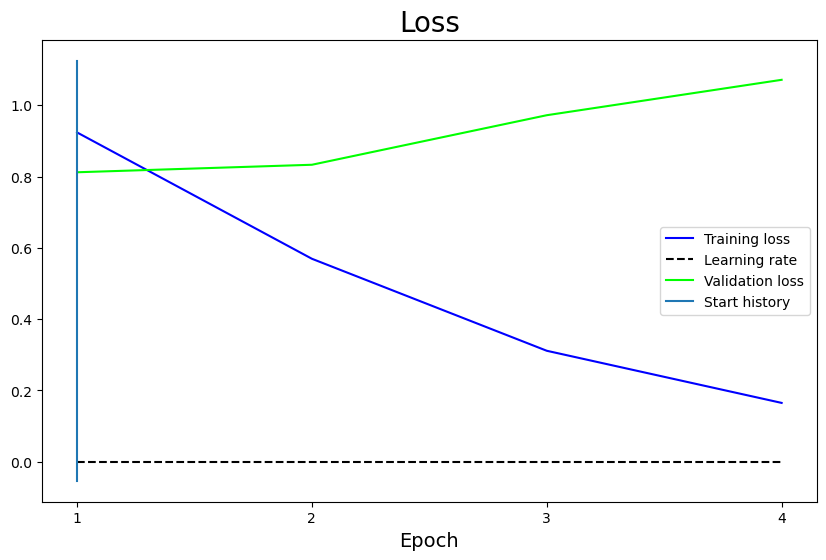

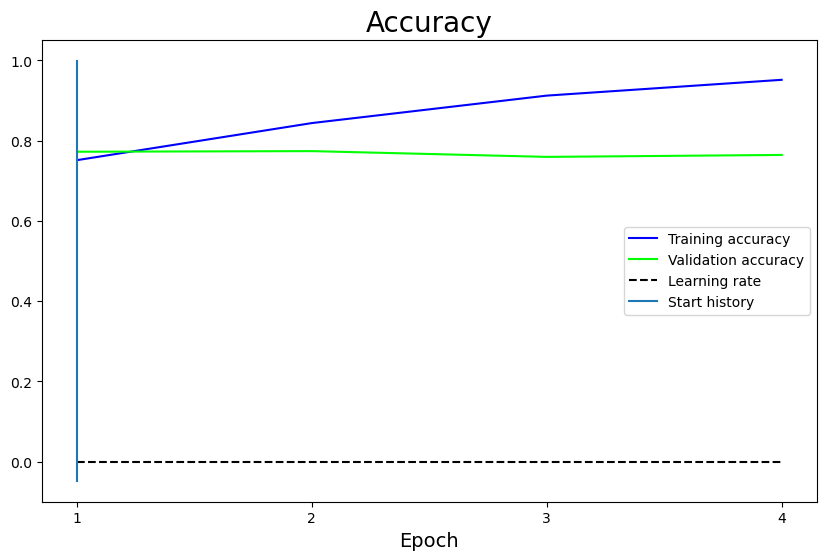

In [40]:
soml.tf.model.plot.plot_history(history=history_loaded_model_2)

In [41]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
soml.tf.model.io.save_model_alt(model=loaded_model_2, directory="./saved_models", name="loaded_model_2")

In [42]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
loaded_model_2_evaluation = loaded_model_2.evaluate(test_data_pre)
loaded_model_2_evaluation

790/790 [==============================] - 6s 8ms/step - loss: 0.8122 - accuracy: 0.7725


[0.8122107982635498, 0.7725148797035217]

In [43]:
# !tar -zcvf loaded_model_2_model.tar.gz ./saved_models
# !tar -zcvf loaded_model_2_tensorbaord.tar.gz ./logs/loaded_model_2

## TODO: View training results on TensorBoard

To do: Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.

In [44]:
# Download and evaluate fine-tuned model from Google Storage
soml.util.io.download_file(source="https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip", filepath="07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip")
soml.util.io.extract_zip(filepath="07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip", folder='./data')

Download of https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip skipped, file 07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip exists.
Download of https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip completed.


In [45]:
loaded_fine_tuned_gs_model = tf.keras.models.load_model("./data/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [46]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data_pre)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 7s 8ms/step - loss: 0.9072 - accuracy: 0.8016


[0.9072138667106628, 0.8015841841697693]

TODO: Evaluate your trained model

Some ideas you might want to go through:

Find the precision, recall and f1 scores for each class (all 101).
Build a confusion matrix for each of the classes.
Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).
See the evaluation section at the end of Transfer Learning Part 3: Scaling Up for more: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

In [47]:
# Load the model again in case the colab environment has been restarted.
# loaded_model_2 = mll.load_model_alt(directory="/content/saved_models", name="loaded_model_2", format="h5")
# loaded_model_2.compile(loss=sparse_categorical_crossentropy,
#                        optimizer=Adam(0.001 * 0.1),
#                        metrics=["accuracy"])

In [48]:
y_prob = loaded_fine_tuned_gs_model.predict(test_data_pre)
y_prob

790/790 [==============================] - 6s 7ms/step


array([[8.8489201e-04, 1.0999515e-11, 2.4506319e-09, ..., 8.3253133e-07,
        2.0961366e-09, 3.4590417e-03],
       [8.5576995e-10, 4.0888005e-12, 2.8220301e-10, ..., 2.5587061e-12,
        3.3653645e-08, 1.1004858e-12],
       [3.1541460e-11, 1.8254797e-11, 9.3770293e-13, ..., 5.6874557e-13,
        2.2766274e-10, 9.5246955e-13],
       ...,
       [1.9758055e-04, 9.5889027e-07, 2.2975127e-14, ..., 1.1583849e-09,
        4.3220572e-07, 9.7809469e-05],
       [1.3693228e-14, 6.0946538e-21, 7.6604970e-20, ..., 2.1516758e-22,
        1.0265072e-21, 8.0160564e-17],
       [9.0048870e-06, 2.1882623e-10, 2.9570367e-08, ..., 2.0730427e-06,
        3.1973187e-08, 3.7167607e-07]], dtype=float32)

In [49]:
# labels_pre = get_labels_from_dataset(train_data_pre)
labels = soml.tf.dataset.get_labels(test_data_pre)

In [50]:
# Calculate accuracy
sklearn_accuracy = soml.evaluate.analyze.quality_metrics(y_true=labels, y_prob=y_prob)
sklearn_accuracy

{'accuracy': 80.15841584158416,
 'f1-score': 0.8018884758016779,
 'precision': 0.8037853957663307,
 'recall': 0.8015841584158416,
 'support': None}

In [51]:
y_prob[:10]

array([[8.84892012e-04, 1.09995147e-11, 2.45063192e-09, ...,
        8.32531327e-07, 2.09613660e-09, 3.45904171e-03],
       [8.55769955e-10, 4.08880048e-12, 2.82203011e-10, ...,
        2.55870607e-12, 3.36536452e-08, 1.10048580e-12],
       [3.15414604e-11, 1.82547970e-11, 9.37702932e-13, ...,
        5.68745571e-13, 2.27662736e-10, 9.52469549e-13],
       ...,
       [2.71993938e-09, 2.63943869e-14, 2.37594710e-12, ...,
        6.46822311e-15, 1.01180024e-13, 2.91719773e-11],
       [1.23448159e-15, 6.46822141e-15, 5.22712449e-16, ...,
        5.16776902e-14, 6.65348399e-09, 1.53633735e-15],
       [2.45228577e-02, 2.94916580e-09, 6.93577418e-11, ...,
        2.04834985e-04, 4.74688106e-13, 9.70516384e-01]], dtype=float32)

In [52]:
soml.util.label.is_multiclass_classification(y_prob=y_prob)

True

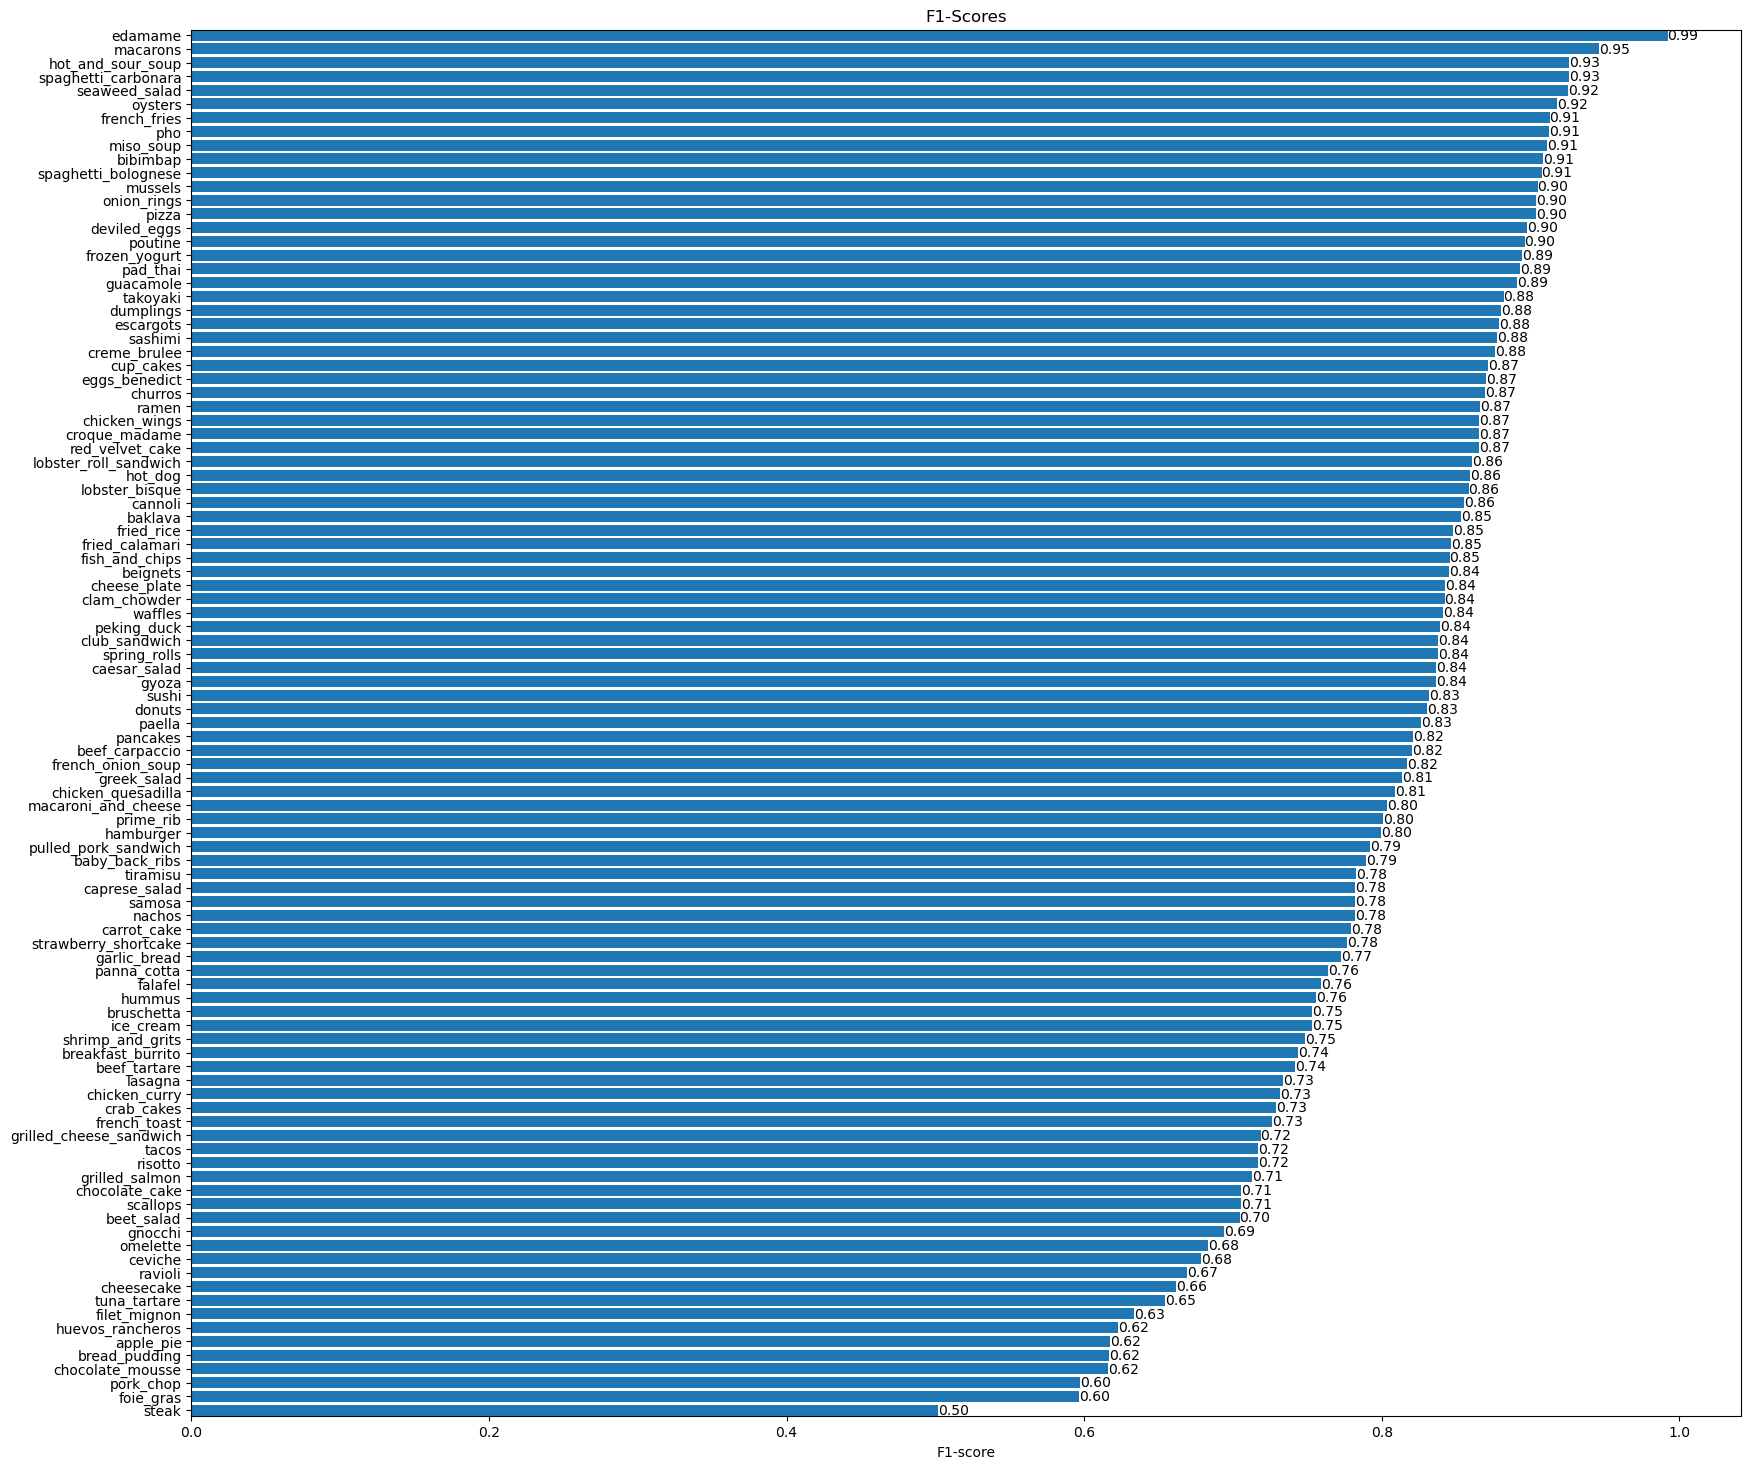

In [53]:
soml.evaluate.plot.report_f1_score(y_true=labels, y_prob=y_prob, class_names=class_names, figsize=(20, 18))

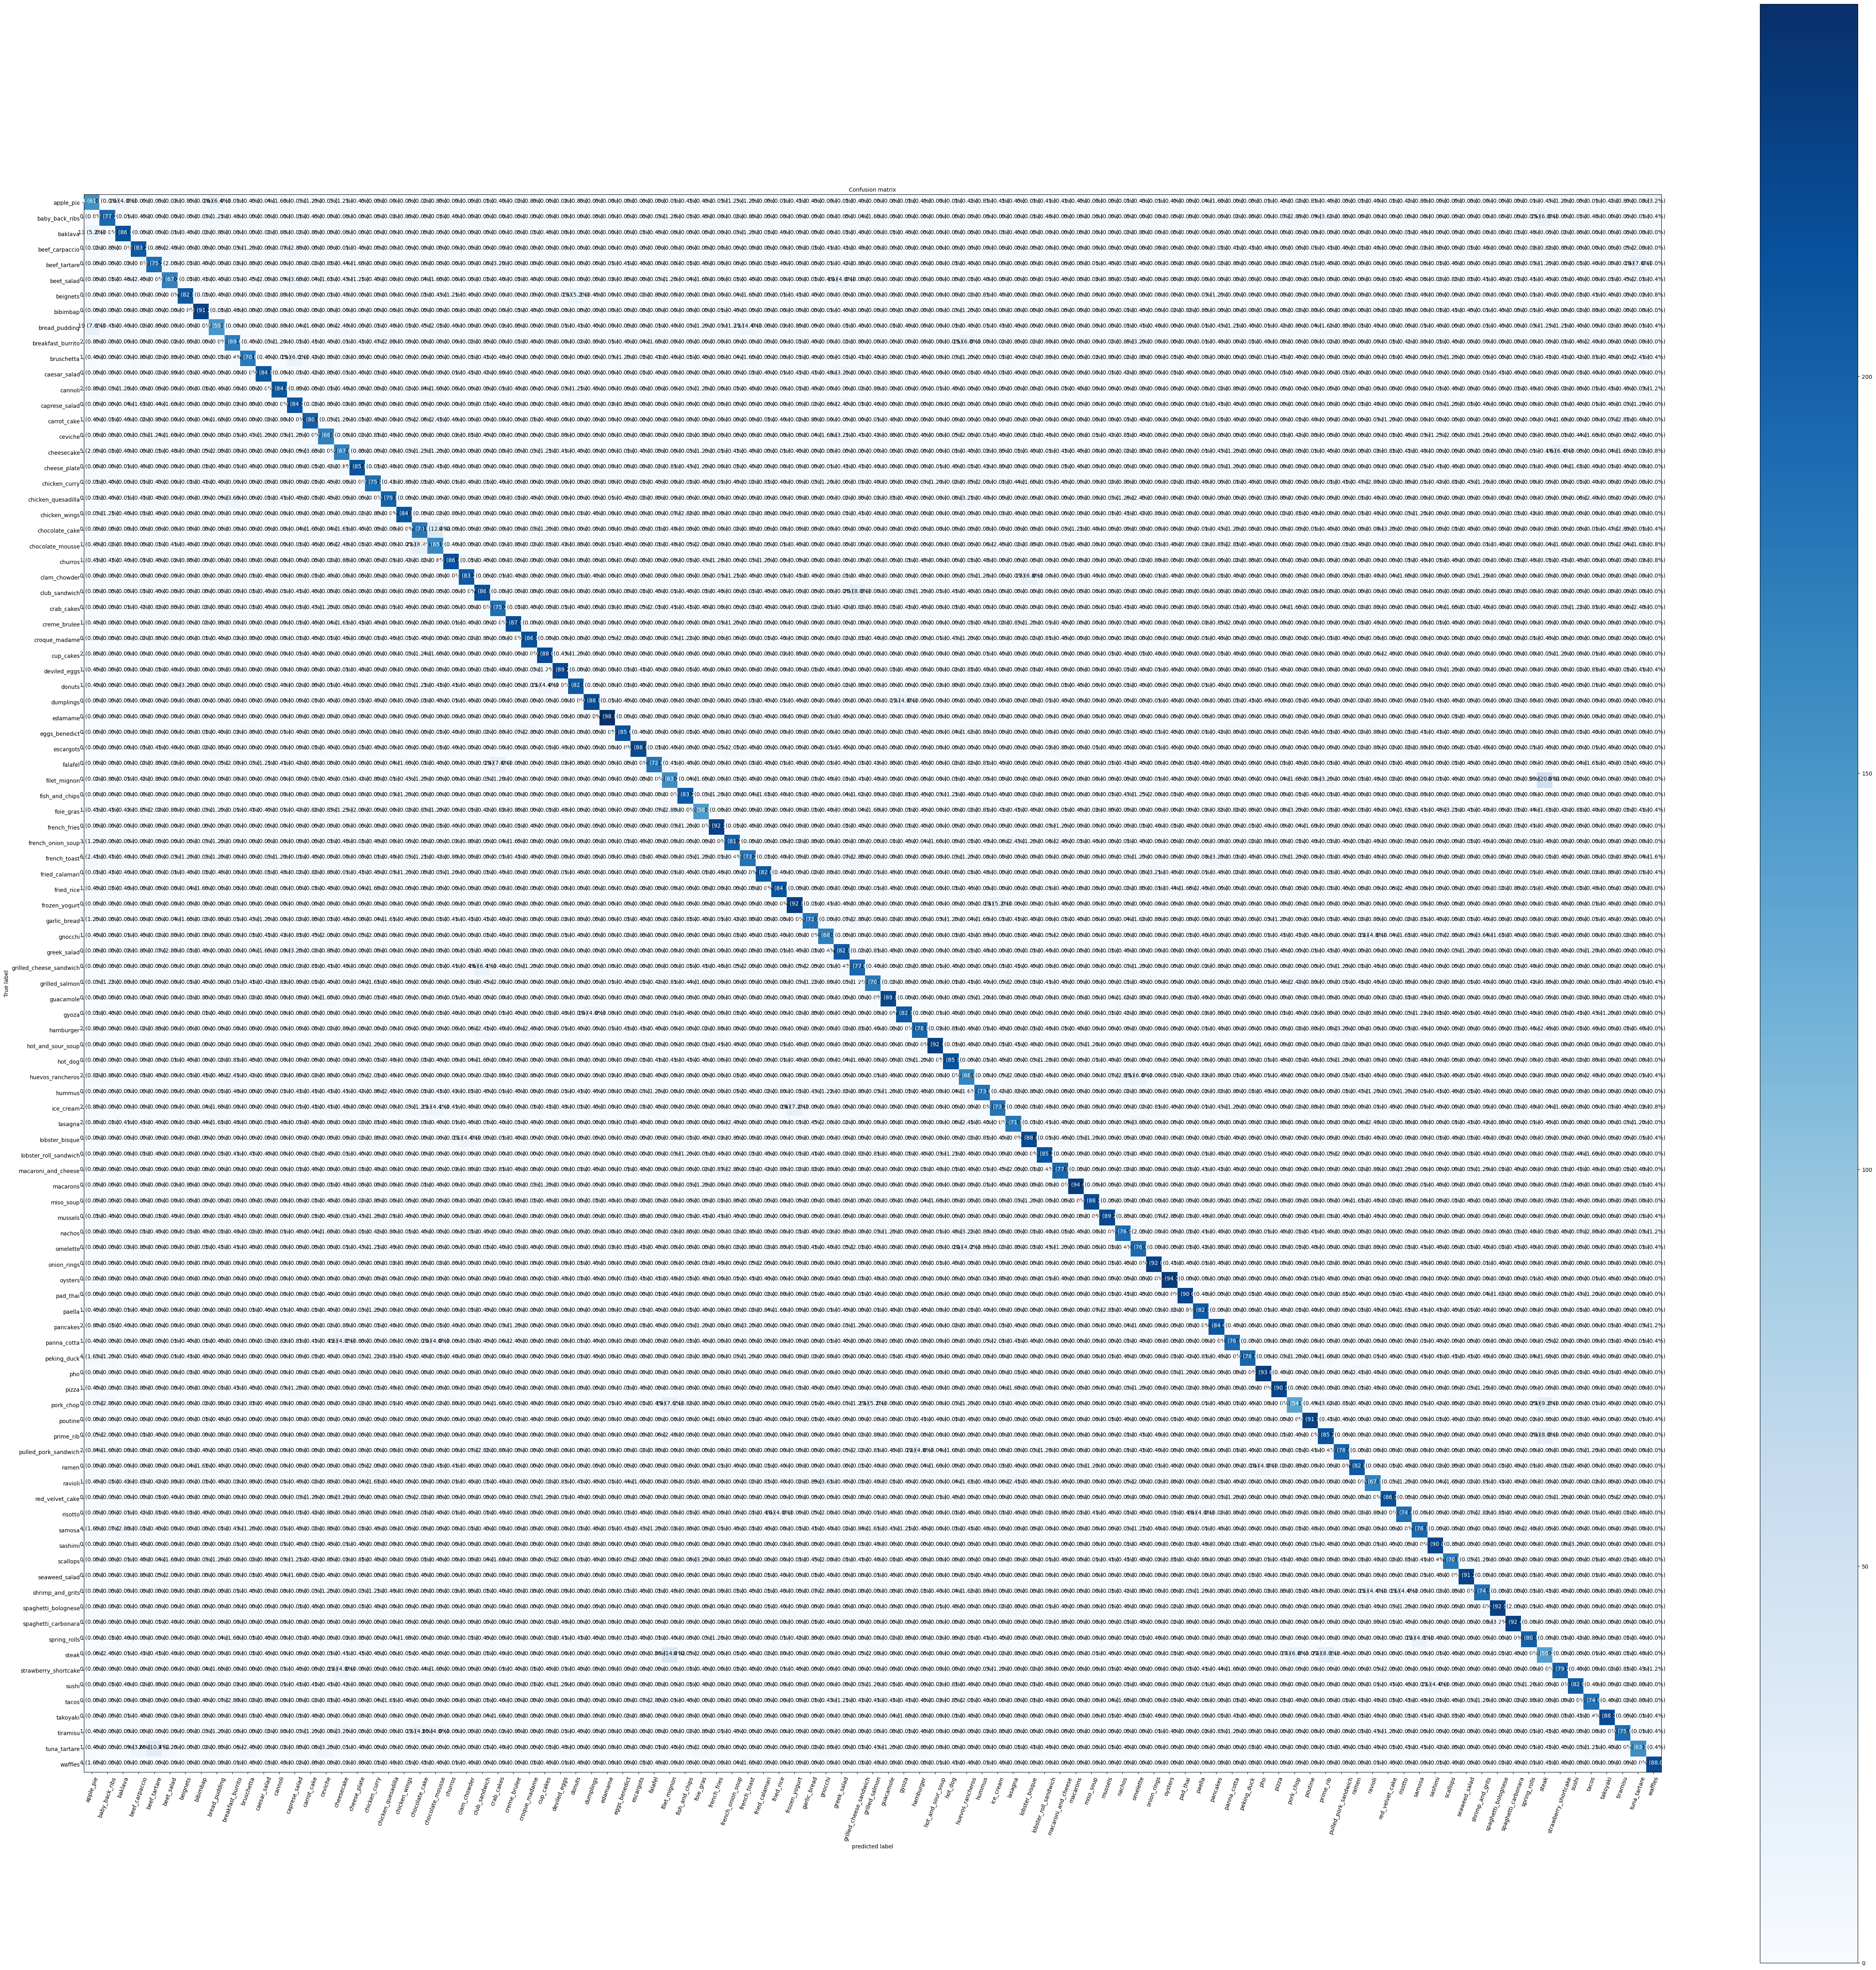

In [54]:
soml.evaluate.plot.confusion_matrix(y_true=labels, y_prob=y_prob, class_names=class_names, figsize=(64, 64), norm=True, savefig=True)

Exercises

1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:
* A confusion matrix between all of the model's predictions and true labels.
* A graph showing the f1-scores of each class.
* A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.
2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?
4. Name one important benefit of mixed precision training, how does this benefit take place?

## Extra-curriculum

* Read up on learning rate scheduling and the learning rate scheduler callback. What is it? And how might it be helpful to this project?
* Read up on TensorFlow data loaders (improving TensorFlow data loading performance: https://www.tensorflow.org/guide/data_performance). Is there anything we've missed? What methods you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a gret round up of ideas.
* ead up on the documentation for TensorFlow mixed precision training: https://www.tensorflow.org/guide/mixed_precision. What are the important things to keep in mind when using mixed precision training?